<a href="https://colab.research.google.com/github/Wattsy2020/DeepLearningA1/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP5329 Assignment 1

Team Member
- Mirope Yuhao Hu, SID: 470139936
- Sean Hongbo Du,	SID: 500635346
- Liam Watts, SID: 510562348


### Liam Watts: 1, 2, 6 - More than 1 hidden layer, ReLU Activation, Softmax output layer and cross entroppy loss
### Mirope: 4, 3, 8 - Momentum in SGD, weight decay, batch normalization
### Sean: 5, 7, 0 - dropout, mini-batch training, data preprocess

## How to run the code

## All necessary Imports

__NOT__ allowed:
1. use Deep Learning frameworks (e.g. PyTorch, Tensorflow, Caffe, and KERAS)
2. any kinds of auto-grad tools (e.g. autograd)
3. sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Loading/Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load data -> subject to change for the final version
dir_name = '/content/drive/MyDrive/Colab Notebooks/COMP5329/Ass1/Assignment1-Dataset/'

test_data = np.load(dir_name + 'test_data.npy')
test_label = np.load(dir_name + 'test_label.npy')
train_data = np.load(dir_name + 'train_data.npy')
train_label = np.load(dir_name + 'train_label.npy')

print('Shape of original train data is:\t', train_data.shape,
      '\nShape of original train label is:\t', train_label.shape,
      '\nShape of original test data is:\t\t', test_data.shape,
      '\nShape of original test label is:\t', test_label.shape )

# print('\nAll labels are:\t\t', list(np.unique(test_label)))

# # preprocessing: normalization might be unnecessary
# # test_x = Normalizer().fit_transform(test_data)
# # train_x = Normalizer().fit_transform(train_data)

# one hot encoding the labels set 
def oneHot_encoder(data_label):
    '''returns the labels in one hot encoders'''
    encoded = list()
    for value in data_label:
        label_onehot = [0 for index in range(10)]
        label_onehot[int(value)] = 1
        encoded.append(label_onehot)
    return np.array(encoded)


test_x = test_data
train_x = train_data
test_y = oneHot_encoder(test_label)
train_y = oneHot_encoder(train_label)

print('\nShape of transformed train label is:\t', train_y.shape,
      '\nShape of transformed train label is:\t', test_y.shape )

Shape of original train data is:	 (50000, 128) 
Shape of original train label is:	 (50000, 1) 
Shape of original test data is:		 (10000, 128) 
Shape of original test label is:	 (10000, 1)

Shape of transformed train label is:	 (50000, 10) 
Shape of transformed train label is:	 (10000, 10)


## Data Preprocessing



Data were normalized via dividing by the maximum positive number in the column.  

To visualize the dataset, the test data were transformed from (10000, 128) to (10000, 2, 64). According to the scatter plot of the nine classes, there is not much differences of the scatter plots between the classes. 

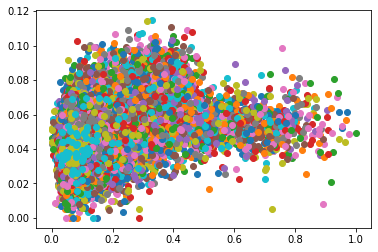

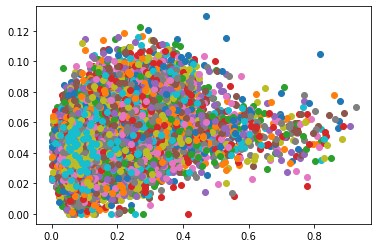

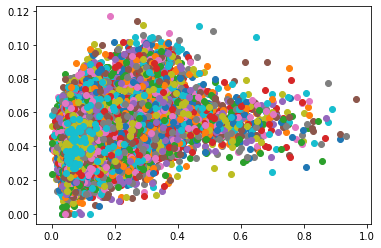

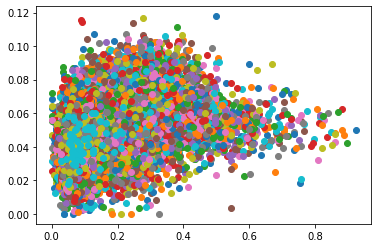

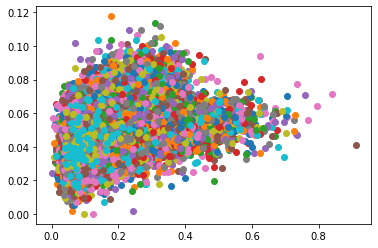

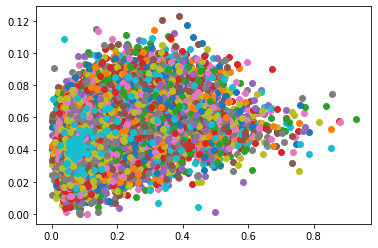

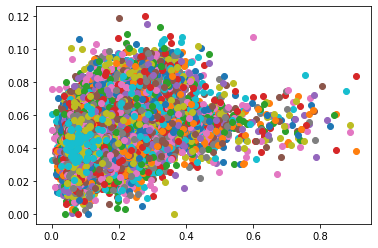

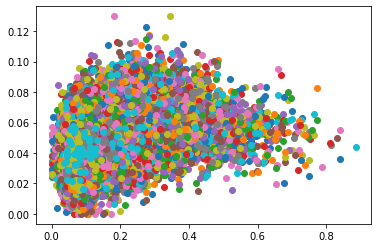

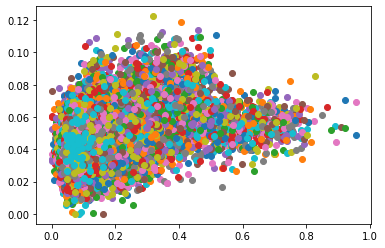

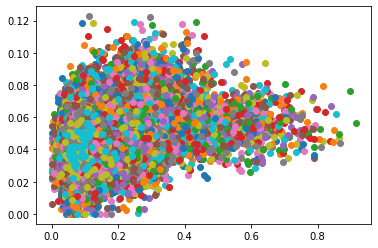

In [4]:
# data normalization: [0, 1]
def normalization(dataset):
    numer = test_data - test_data.min(axis = 0)
    denom = dataset.max() - dataset.min()
    return numer/denom

pre_train_data = normalization(train_data).transpose()
pre_test_data = normalization(test_data).transpose()

# reframe labels as DataFrame and renaming  
train_label_df = pd.DataFrame(train_label).rename(columns={0: "class"})
test_label_df = pd.DataFrame(test_label).rename(columns={0: "class"})

# combining data and labels as DataFrame
train_df = pd.concat([pd.DataFrame(pre_train_data), train_label_df.transpose()], axis=0).transpose()
test_df = pd.concat([pd.DataFrame(pre_test_data), test_label_df.transpose()], axis=0).transpose()

# plot the dataset by their labels
for num in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    extracted_data = test_df[test_df['class'] == num]
    test_df_dat = extracted_data[extracted_data.columns[0:128]]
    for i in test_df_dat.transpose():
        plt.scatter(np.array(test_df_dat.transpose()[i]).reshape(2, 64)[0], np.array(test_df_dat.transpose()[i]).reshape(2, 64)[1])
    plt.show()


## Algorithms / Structures

__Requirements__
1. More than one hidden layer
2. ReLU activation
3. Weight decay
4. Momentum in SGD
5. Dropout
6. Softmax and cross-entropy 
7. Mini-batch training
8. Batch Normalization

In this part, try to implement each layer/optimiser/function as modules

In [ ]:
# Liam Watts: 1, 2, 6 - activation, layer, softmax
# Mirope: 4, 3, 8 - Momentum in SGD, weight decay, batch normalization
# Sean: 5, 7, 0 - dropout, mini-batch training, data preprocess

In [6]:
# Define functions required for the Multi Layer Perceptron
def he_uniform(input_size=1, output_size=1):
    '''outputs a matrix of size (output_size, input_size) with random initialization'''
    r = np.sqrt(6/input_size)
    return np.random.uniform(-r, r, size=(output_size, input_size))

def relu(matrix):
    '''return the elementwise ReLU activation of the matrix'''
    return np.maximum(matrix, 0)

def drelu(matrix):
    '''
    parameters:
        matrix: the relu activations
    
    outputs:
        the derivative for relu on every element of the matrix
    '''
    return np.minimum(np.maximum(matrix, 0), 1) # this defines the derivative of relu at 0 as 0 to tf.nn.relu()'s standard (which ensures a sparser gradient matrix)

# define the sigmoid function for testing, it's easier to implement backprop on sigmoid than softmax
def sigmoid(matrix):
    '''return sigmoid on every element of the matrix'''
    return 1/(1 + np.power(np.e, -matrix))

def dlogsigmoid(matrix):
    '''
    parameters:
        matrix: the sigmoid activations
    
    outputs:
        the derivative for log sigmoid on every element of the matrix
    '''
    return (1 - matrix) # dsigmoid = sigmoid(1 - sigmoid)  so dlog(sigmoid) = sigmoid(1 - sigmoid)/sigmoid = (1 - sigmoid)

def softmax(matrix):
    '''return the softmax activation of a matrix (each row vector has softmax applied to it)'''
    matrix = np.power(np.e, matrix)
    total = np.sum(matrix, axis=1).reshape(matrix.shape[0], 1)
    return matrix/total # here we broadcast total (a vector) to divide each row in the matrix, broadcasting is frequently used to vectorize our code

In [8]:
class MLP:
    ''' 
    Implements a Multi Layer Perceptron, including both the feed-forward phase and backward propagation
    The output activation must be softmax, and the loss function cross entropy

    MLP.__init__()
        parameters:
            hidden: an array with the number of neurons for each layer
            input_size: number of inputs
            output_size: number of outputs
            output_act: the activation for the last layer, one of sigmoid or softmax
        
        initializes weight matrices with shape (output_size, input_size) to match Pytorch's standard
    '''
    def __init__(self, hidden=[1], input_size=1, output_size=1, output_act=softmax, learn_rate=0.01, initializer=he_uniform):
        '''initialize the weight and bias matrices for each layer, along with other hyperparameters'''
        self.weights = []
        self.biases = []
        for input_size_i, output_size_i in zip([input_size] + hidden, hidden + [output_size]):
            self.weights.append(initializer(input_size=input_size_i, output_size=output_size_i)) # TODO: use xavier intialization instead for the softmax layer?
            self.biases.append(np.zeros((output_size_i, 1)))

        self.output_act = output_act
        self.learn_rate=learn_rate

    def forward(self, X):
        '''
        calculate output of the network, storing the hidden states in self.activations (activations[0] is the feature input)
        
        parameters:
            X: the input matrix of shape (batch_size, input_size)

        returns:
            yhat: the prediction matrix of shape (batch_size, output_size)
        '''
        self.activations = [X]
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            if i == len(self.weights) - 1: # use the output activation
                activation = self.forward_one_layer(self.activations[i], w, b, activation=self.output_act)
            else:
                activation = self.forward_one_layer(self.activations[i], w, b, activation=relu)
            self.activations.append(activation)
        return self.activations[-1]

    def forward_one_layer(self, inputs, weights, biases, activation=relu):
        '''
        compute the output of a layer for certain inputs, return the output
        
        we follow the pytorch standard, so shapes are as follows:
        inputs: a matrix of shape (batch_size, feature_size)
        weights: a matrix of shape (output_size, feature_size)
        biases: a matrix of shape (output_size, 1)
        returns: a matrix of shape (batch_size, output_size)
        '''
        linear = np.dot(inputs, weights.T) + biases.T
        return activation(linear)

    def backprop(self, y, yhat):
        '''given the true outputs y and predictions yhat, perform one step of gradient descent'''
        assert self.activations != [], "forward propagate first before back propagation" # we need the hidden states
        # get the derivative of cross-entropy loss for the output
        dloss = yhat - y # Interestingly this is the same, regardless of sigmoid or softmax activation (softmax was designed as a generalised sigmoid)
                         # A derivation and explanation of the derivatives for categorical-cross entropy is here: https://peterroelants.github.io/posts/cross-entropy-softmax/

        # do backprop layer by layer, passing to each layer the derivative of loss w.r.t that layer's outputs
        for layer in range(len(self.weights) - 1, -1, -1):
            dloss = self.backprop_one_layer(dloss, layer)
        self.activations = [] # reset the activations to avoid using them twice for the same backprop

    def backprop_one_layer(self, dloss, i):
        '''
        backpropagate one layer of the model
        parameters:
            i: the index of the layer to propagate in self.weights and self.biases
            dloss: loss of the output (pre relu) of this layer, shape of (batch_size, layer_output_size)
        
        updates the weights and biases by subtracting the gradient

        returns:
            dloss: loss of the output (pre relu) of the previous layer (layer i-1), so long as layer i-1 exists (i.e. i-1 >= 0)
        '''
        assert dloss is not None, "Output deltas not provided"

        # outline dimensions
        batch_size = dloss.shape[0]
        layer_output_size = dloss.shape[1]
        layer_input_size = self.activations[i].shape[1]
        
        # calculate gradients
        activation = self.activations[i].reshape(batch_size, layer_input_size) # use reshapes to assert the shape is correct, and indicate shape
        dw = np.dot(dloss.T, activation).reshape(layer_output_size, layer_input_size)
                                         # the i,j entry of dw represents the dot product of:
                                         # the ith row of dloss.T i.e. the derivative of losses for neuron i over all samples
                                         # the jth column of activation i.e. the input to weight j over all samples
                                         # so overall: it is (dloss for neuron i * input for weight j of neuron i), giving us the derivative of loss w.r.t weight i,j
        db = np.sum(dloss.T, axis=1).reshape(layer_output_size, 1)
                                     # output = X*W.T + B so doutput w.r.t db is just 1, hence we only need to sum the gradients for each bias
        
        # calculate gradient of loss w.r.t output of previous layer (if there is a previous layer)
        if i != 0:
            dloss_prev = np.dot(dloss, self.weights[i]).reshape(batch_size, layer_input_size)
                                          # the i,j entry of dloss_prev represents the dot product of
                                          # the ith row of dloss i.e. the dlosses for the ith sample for each of this layers outputs
                                          # the jth column of W i.e. the jth weight for all output neurons in this layer
                                          # overall: the sum of (dloss of output neuron k * weight j (the weight that multiplies input j) of output neuron k for sample i)
                                          # which is the derivative of the loss w.r.t input j for this sample as output = X*W.T + B
            dloss_prev = dloss_prev * drelu(activation) # multiply by the derivatives of the previous layers activations
        else:
            dloss_prev = None

        # update gradients
        self.weights[i] -= (self.learn_rate/batch_size)*dw
        self.biases[i] -= (self.learn_rate/batch_size)*db

        return dloss_prev

In [9]:
# test sigmoid MLP training
# create a synthetic dataset for training
X = np.random.rand(10000, 100)
y = (np.sum(X, axis=1) > 50) # the task is to identify if the sum of 100 numbers is greater than 50
y = y.reshape(10000, 1)

In [12]:
mlp = MLP(hidden=[100], input_size=100, output_size=1, output_act=sigmoid, learn_rate=0.01)

# get accuracy function
def test_accuracy(mlp, X, y):
    preds = mlp.forward(X) > 0.5
    accuracy = np.mean(preds == y)
    return accuracy

# train model
batch_size = 100
for epoch in range(1000):
    # shuffle
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices, :]
    y = y[indices, :]

    for batch in range(int(X.shape[0]/batch_size)):
        batch_x = X[batch*batch_size:(batch+1)*batch_size]
        batch_y = y[batch*batch_size:(batch+1)*batch_size]
        preds = mlp.forward(batch_x)
        mlp.backprop(batch_y, preds)

    if epoch % 50 == 0:
        print("Epoch {}    Accuracy: {}".format(epoch, test_accuracy(mlp, X, y)))

Epoch 0    Accuracy: 0.5104
Epoch 50    Accuracy: 0.6696
Epoch 100    Accuracy: 0.7425
Epoch 150    Accuracy: 0.7884
Epoch 200    Accuracy: 0.8437
Epoch 250    Accuracy: 0.8797
Epoch 300    Accuracy: 0.9194
Epoch 350    Accuracy: 0.935
Epoch 400    Accuracy: 0.9559
Epoch 450    Accuracy: 0.9595
Epoch 500    Accuracy: 0.9687
Epoch 550    Accuracy: 0.9725
Epoch 600    Accuracy: 0.9788
Epoch 650    Accuracy: 0.9657
Epoch 700    Accuracy: 0.9822
Epoch 750    Accuracy: 0.9826
Epoch 800    Accuracy: 0.9853
Epoch 850    Accuracy: 0.989
Epoch 900    Accuracy: 0.982
Epoch 950    Accuracy: 0.987


In [11]:
mlp.weights[-1], mlp.biases[-1]

(array([[-0.30589913,  0.5397344 , -0.7678027 , -0.50135883, -1.92239626,
         -0.28189634,  0.28601508, -0.14035365,  0.55748188,  7.33706456]]),
 array([[-4.88773232]]))

In [13]:
%time
mlp = MLP(hidden=[64], input_size=128, output_size=10, output_act=softmax)

batch_size = 100
X = train_x
y = train_y

def accuracy(y_hat, y):
    preds = np.argmax(y_hat, axis=1)
    labels = np.argmax(y, axis=1)
    return np.mean(preds == labels)

for epoch in range(1000):
    # shuffle
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices, :]
    y = y[indices, :]

    for batch in range(int(X.shape[0]/batch_size)):
        batch_x = X[batch*batch_size:(batch+1)*batch_size]
        batch_y = y[batch*batch_size:(batch+1)*batch_size]
        preds = mlp.forward(batch_x)
        mlp.backprop(batch_y, preds)

    if epoch % 50 == 0:
        print("Epoch {:04d}\tTrain Accuracy: {:.4f}\tTest Accuracy: {:.4f}"
        .format(epoch, accuracy(mlp.forward(X), y), accuracy(mlp.forward(test_x), test_y)))


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
Epoch 0000	Train Accuracy: 0.2927	Test Accuracy: 0.2946
Epoch 0050	Train Accuracy: 0.5161	Test Accuracy: 0.4882
Epoch 0100	Train Accuracy: 0.5473	Test Accuracy: 0.5066
Epoch 0150	Train Accuracy: 0.5642	Test Accuracy: 0.5137
Epoch 0200	Train Accuracy: 0.5756	Test Accuracy: 0.5132
Epoch 0250	Train Accuracy: 0.5820	Test Accuracy: 0.5147
Epoch 0300	Train Accuracy: 0.5867	Test Accuracy: 0.5116
Epoch 0350	Train Accuracy: 0.5916	Test Accuracy: 0.5179
Epoch 0400	Train Accuracy: 0.5942	Test Accuracy: 0.5137
Epoch 0450	Train Accuracy: 0.5963	Test Accuracy: 0.5129
Epoch 0500	Train Accuracy: 0.5982	Test Accuracy: 0.5128
Epoch 0550	Train Accuracy: 0.5984	Test Accuracy: 0.5111
Epoch 0600	Train Accuracy: 0.5996	Test Accuracy: 0.5102
Epoch 0650	Train Accuracy: 0.6000	Test Accuracy: 0.5103
Epoch 0700	Train Accuracy: 0.6001	Test Accuracy: 0.5063
Epoch 0750	Train Accuracy: 0.6008	Test Accuracy: 0.5062
Epoch 0800	Train Accuracy: 0.6021	Test A

## Experiments

In [ ]:
# the baseline model
def baseline_model():
	# create model
    model = Sequential()
    model.add(Dense(512, input_dim=128, activation='relu')) # 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1)) # 5
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1)) # 5
    model.add(BatchNormalization()) # 8
    model.add(Dense(10, activation='softmax')) # 1, 6.1
    opt = SGD(lr=0.3, momentum=0.9, decay=0.001) # optimizers: 3, 4
    # 6.2
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

  
# Crossing Validation
def training(model, epoches=20, batch_size=256):
  for i in epoches:
    